In [1]:
!pip install -q --upgrade "httpx[http2]" tqdm pandas matplotlib datasets



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
VLLM = "https://llama3-vllm-vs-tgis.apps.cluster-jj67w.jj67w.sandbox1788.opentlc.com"
TGI  = "https://llama3-default.apps.cluster-jj67w.jj67w.sandbox1788.opentlc.com"
MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"

WARMUP_SECS = 20          # settle CUDA graphs / flash-cache
DUR_SECS    = 40          # measurement window
CONCURRENCY = [1, 4, 8, 16, 32]

HEADERS = {"Content-Type": "application/json"}


In [3]:
from datasets import load_dataset
import random, textwrap, os

LOCAL_PROMPT_FILE = "prompts.txt"

# Load from disk if file exists
if os.path.exists(LOCAL_PROMPT_FILE):
    with open(LOCAL_PROMPT_FILE, "r") as f:
        prompts = [line.strip() for line in f if line.strip()]
    print(f"✅ Loaded {len(prompts)} prompts from {LOCAL_PROMPT_FILE}")
else:
    # Download from Hugging Face and save locally
    dataset = load_dataset("wikipedia", "20220301.en", split="train[:1%]").shuffle(seed=42)
    prompts = dataset["text"][:1000]
    with open(LOCAL_PROMPT_FILE, "w") as f:
        for prompt in prompts:
            f.write(prompt.replace('\n', ' ') + "\n")
    print(f"📥 Downloaded and saved {len(prompts)} prompts to {LOCAL_PROMPT_FILE}")

print(textwrap.fill(random.choice(prompts), 90))

✅ Loaded 1000 prompts from prompts.txt
Chief Clarence "Clancy" Wiggum is a fictional character from the animated television
series The Simpsons, voiced by Hank Azaria. He is the chief of police in the show's
setting of Springfield, and is the father of Ralph Wiggum and the husband of Sarah Wiggum.
Gluttonous, irresponsible, and immature, Wiggum is often too lazy and cowardly to bother
fighting crime. His more responsible subordinate officers Eddie and Lou play the straight
men to his shenanigans.  Character development   His surname "Wiggum" is Matt Groening's
mother's maiden name. As "a conscious pun", Wiggum was designed to look like a pig. Hank
Azaria first based his voice for Wiggum on David Brinkley, but it was too slow and he
switched it to an Edward G. Robinson impression.  Biography  Chief Wiggum is of Irish
descent. Per the episode "Raging Abe Simpson and His Grumbling Grandson in 'The Curse of
the Flying Hellfish', Wiggum's father Iggy served in Abe Simpson's infantry squad,


In [4]:
import httpx, warnings, json, re
warnings.filterwarnings("ignore", message="Unverified HTTPS")

def discover(base):
    probes = [("/v1/chat/completions", {"model":MODEL_ID,"messages":[{"role":"user","content":"Hi"}],"stream":False}),
              ("/v1/completions",      {"model":MODEL_ID,"prompt":"Hi","stream":False}),
              ("/generate",            {"prompt":"Hi","max_tokens":4})]
    for p,body in probes:
        try:
            r=httpx.post(base+p,headers=HEADERS,json=body,timeout=10,verify=False)
            if r.status_code==200:
                return p,body
        except Exception: pass
    raise RuntimeError(f"No working path on {base}")

VLLM_PATH,VLLM_BODY = discover(VLLM); TGI_PATH,TGI_BODY = discover(TGI)
print("vLLM →",VLLM_PATH,"\nTGI  →",TGI_PATH)


vLLM → /v1/chat/completions 
TGI  → /v1/chat/completions


In [5]:
import asyncio, time, statistics as st, pandas as pd
from tqdm.auto import tqdm

def make_body(template, prompt):
    body = json.loads(json.dumps(template))    # deep-copy
    if "prompt" in body:                   body["prompt"]   = prompt
    elif "messages" in body:               body["messages"][-1]["content"] = prompt
    return body

async def _worker(base, path, template, bag, stop):
    async with httpx.AsyncClient(http2=True, verify=False, timeout=120) as c:
        while time.time() < stop:
            body = make_body(template, random.choice(prompts))
            t0 = time.perf_counter()
            try:
                r = await c.post(base+path, headers=HEADERS, json=body)
                lat = time.perf_counter() - t0
                if r.status_code == 200:
                    tok = r.json().get("usage",{}).get("completion_tokens",0)
                    bag.append((lat,tok))
            except Exception: pass

async def bench(name, base, path, template, n):
    # warm-up
    await asyncio.gather(*[_worker(base,path,template,[],time.time()+WARMUP_SECS) for _ in range(min(4,n))])
    # measure
    bag=[]; stop=time.time()+DUR_SECS
    await asyncio.gather(*[_worker(base,path,template,bag,stop) for _ in range(n)])
    lats=[l for l,_ in bag]; toks=[t for _,t in bag]
    return dict(server=name, conc=n, rps=round(len(lats)/DUR_SECS,2),
                tok_s=round(sum(toks)/DUR_SECS,1),
                p50=round(st.median(lats)*1000,1) if lats else None,
                p95=round(sorted(lats)[int(.95*len(lats))-1]*1000,1) if lats else None)

rows=[]
for n in CONCURRENCY:
    print(f"### concurrency = {n}")
    rows += await asyncio.gather(
        bench("vLLM",VLLM,VLLM_PATH,VLLM_BODY,n),
        bench("TGI", TGI, TGI_PATH, TGI_BODY,n))
df = pd.DataFrame(rows).set_index(["server","conc"])
df


### concurrency = 1
### concurrency = 4
### concurrency = 8
### concurrency = 16
### concurrency = 32


,,rps,tok_s,p50,p95
server,conc,,,,
vLLM,1,0.05,16.8,20627.6,19149.6
TGI,1,0.07,19.6,16811.6,16811.6
vLLM,4,0.17,58.0,23513.8,25048.9
TGI,4,0.10,21.1,16926.0,17479.7
vLLM,8,0.07,24.8,27204.7,27204.7
TGI,8,0.12,39.2,27839.8,29510.5
vLLM,16,0.07,15.6,27751.8,27751.8
TGI,16,0.25,68.1,25081.5,28214.1
vLLM,32,0.12,20.5,26177.7,26923.1


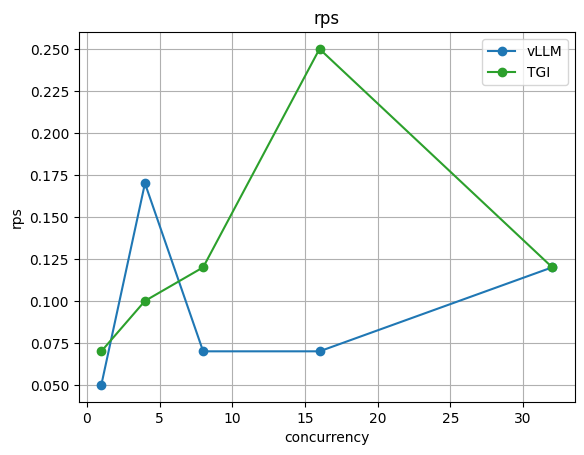

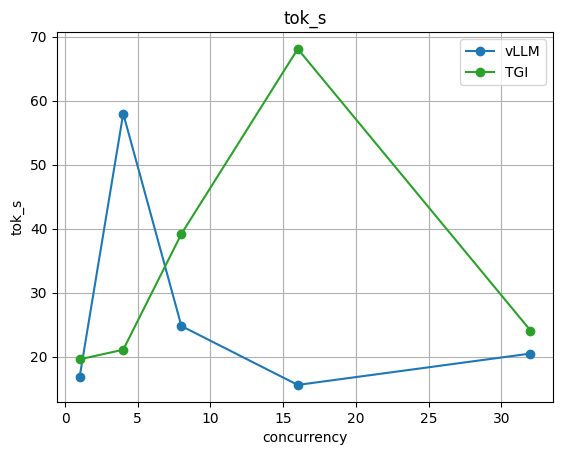

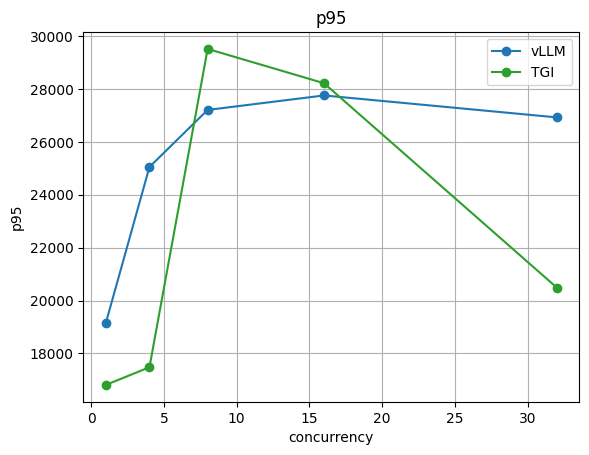

In [6]:
import matplotlib.pyplot as plt

for metric in ("rps","tok_s","p95"):
    plt.figure()
    for srv,color in zip(("vLLM","TGI"),("tab:blue","tab:green")):
        plt.plot(CONCURRENCY, df.loc[srv][metric], "-o", label=srv, color=color)
    plt.title(metric); plt.xlabel("concurrency"); plt.ylabel(metric)
    plt.legend(); plt.grid(True); plt.show()
